In [77]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression ,LogisticRegressionCV
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import accuracy_score ,roc_auc_score ,auc , recall_score , precision_score, f1_score ,roc_curve

#from sklearn.cross_validation import cross_val_score 
data = sm.datasets.fair.load_pandas().data

In [2]:
data['affair'] = (data.affairs >0).astype(int)

In [4]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children +  religious + educ +C(occupation) + C(occupation_husb)', data, return_type="dataframe")

In [5]:
X = X.rename(columns =
{'C(occupation)[T.2.0]':'occ_2',

'C(occupation)[T.3.0]':'occ_3',
'C(occupation)[T.4.0]':'occ_4',
'C(occupation)[T.5.0]':'occ_5',
'C(occupation)[T.6.0]':'occ_6',
'C(occupation_husb)[T.2.0]':'occ_husb_2',
'C(occupation_husb)[T.3.0]':'occ_husb_3',
'C(occupation_husb)[T.4.0]':'occ_husb_4',
'C(occupation_husb)[T.5.0]':'occ_husb_5',
'C(occupation_husb)[T.6.0]':'occ_husb_6'})

y = np.ravel(y)

In [6]:
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [7]:
dataset = data.drop('affairs',axis = 1)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affair           6366 non-null   int32  
dtypes: float64(8), int32(1)
memory usage: 422.9 KB


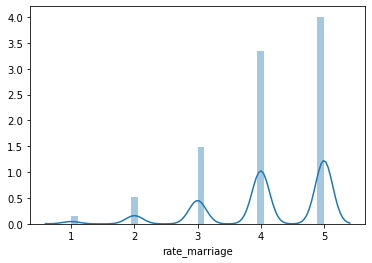

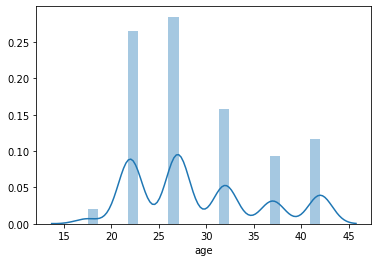

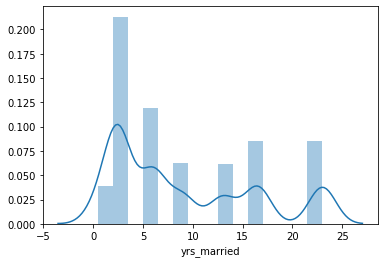

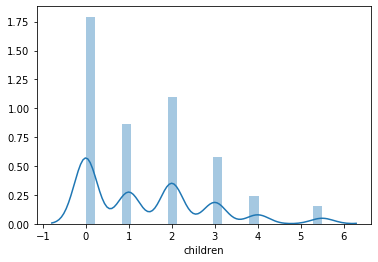

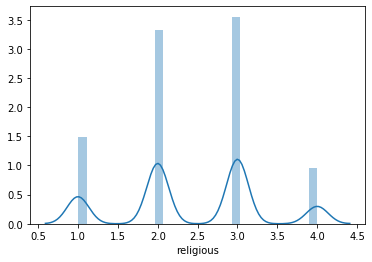

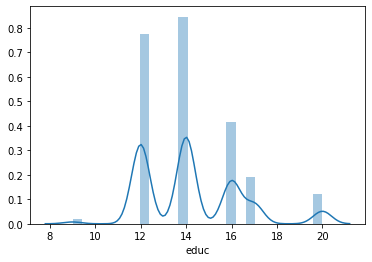

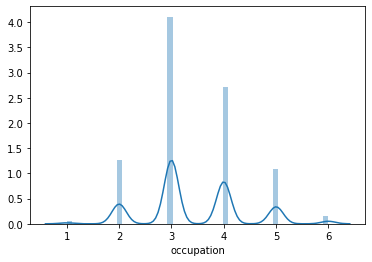

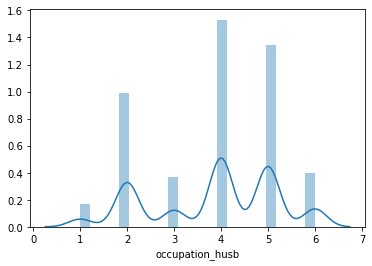

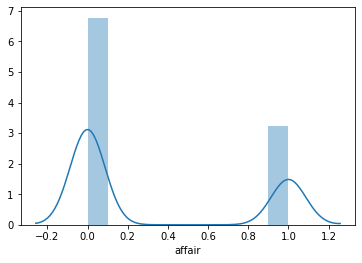

In [9]:
features = dataset.columns
for i in features:
    sns.distplot(dataset[i])
    plt.show()

The features are't normally distributed as we can see from the above visuals

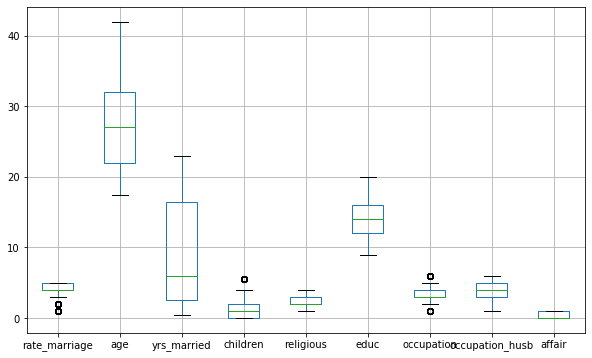

In [10]:
dataset.boxplot(figsize=(10,6))

There is not much outlier associated with this dataset..

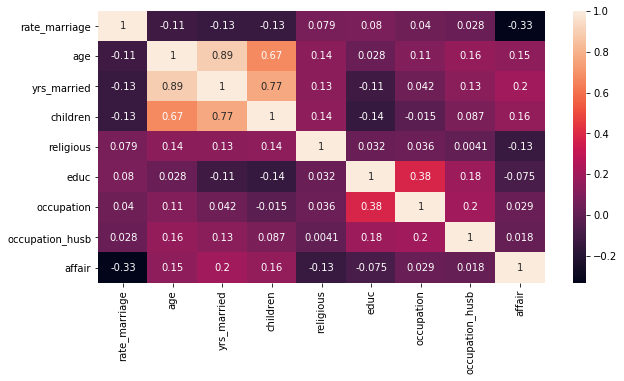

In [11]:
plt.figure(figsize = (10,5))
sns.heatmap(dataset.corr(),annot=True)

- Age , children and Yrs_married features are highly correlated to eachother. So we need to keep only one column from them. or create a new aggrigated column from them. Lets Check Varience inflation factor .

In [12]:
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
df = data.iloc[:,:-2]
sc = StandardScaler()
scd = sc.fit_transform(df)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(scd, i) for i in range(df.shape[1])]
vif["features"] = df.columns

vif

,VIF Factor,features
0,1.034798,rate_marriage
1,5.454116,age
2,7.142949,yrs_married
3,2.528972,children
4,1.036906,religious
5,1.296242,educ
6,1.206863,occupation
7,1.082876,occupation_husb


- age and yrs_married have vif factor more than 5 , so there must be multi-correlation b/w them. So we can drop age column. Or can aggrigate them.

In [13]:
dataset['yr_marr and age'] = dataset['yrs_married'] + dataset['age']
dataset.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair,yr_marr and age
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1,41.0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1,40.0
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1,24.5
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1,53.5
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1,36.0


In [14]:
dataset.drop(['age' , 'yrs_married'],axis =1 ,inplace=True)

In [15]:
dataset.head()

,rate_marriage,children,religious,educ,occupation,occupation_husb,affair,yr_marr and age
0,3.0,3.0,3.0,17.0,2.0,5.0,1,41.0
1,3.0,3.0,1.0,14.0,3.0,4.0,1,40.0
2,4.0,0.0,1.0,16.0,3.0,5.0,1,24.5
3,4.0,4.0,3.0,16.0,5.0,5.0,1,53.5
4,5.0,1.0,1.0,14.0,3.0,4.0,1,36.0


In [16]:
dataset.shape

(6366, 8)

In [17]:
x = dataset.drop('affair',axis = 1)
y = dataset.affair

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X_scaled

array([[-1.15425213,  1.11844056,  0.65334148, ..., -1.51129246,
         0.85406912,  0.2114994 ],
       [-1.15425213,  1.11844056, -1.62378518, ..., -0.4500871 ,
         0.11130901,  0.13876203],
       [-0.11405266, -0.97454634, -1.62378518, ..., -0.4500871 ,
         0.85406912, -0.98866731],
       ...,
       [ 0.92614681, -0.97454634, -0.48522185, ..., -0.4500871 ,
        -2.11697133, -0.98866731],
       [ 0.92614681, -0.27688404,  0.65334148, ..., -0.4500871 ,
         0.11130901, -0.00671273],
       [-0.11405266, -0.97454634, -0.48522185, ..., -1.51129246,
         0.11130901, -0.98866731]])

In [19]:
train_x,test_x, train_y, test_y = train_test_split(X_scaled , y , test_size = 0.30 , random_state = 325)

In [20]:
print(test_x.shape, train_x.shape)

(1910, 7) (4456, 7)


In [21]:
# Model Training
model = LogisticRegression()
model.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
# Create a function of score dataframe.

def score_df(model, test_x , test_y):
    pred_y = model.predict(test_x)
    accuracy = accuracy_score(test_y , pred_y)
    precision = precision_score(test_y , pred_y)
    recall = recall_score(test_y , pred_y)
    f1_scores = f1_score(test_y , pred_y)   
    roc = roc_auc_score(test_y, pred_y)

    score_df = pd.DataFrame(index=['accuracy' , 'precision' , 'recall', 'f1_score','roc_auc_score'], data= [accuracy , precision , recall , f1_scores,roc])
    return score_df

In [76]:
score_df(model , test_x , test_y)

,0
accuracy,0.731414
precision,0.660969
recall,0.370607
f1_score,0.474923
roc_auc_score,0.638964


- Model performance is very poor . We need to work on the threshold part.

In [73]:
def roc_plot(model, test_x , test_y):
    y_pred = model.predict(test_x)
    auc = roc_auc_score(test_y, y_pred)
    fpr, tpr, thresholds = roc_curve(test_y, y_pred)
    
    # plot
    plt.plot(fpr , tpr , color = 'orange' ,label = 'ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)'% auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

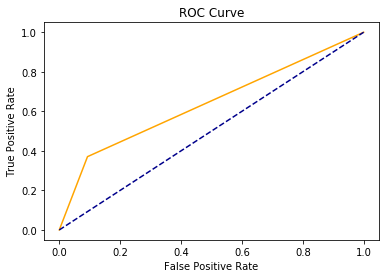

In [74]:
roc_plot(model , test_x , test_y)

In [70]:
clf = LogisticRegression(class_weight="balanced")
clf.fit(train_x,train_y)
THRESHOLD = 0.4
preds = np.where(clf.predict_proba(test_x)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(test_y, preds), recall_score(test_y, preds),
                   precision_score(test_y, preds), roc_auc_score(test_y, preds), f1_score(test_y, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score", "F1_Score"])

,0
accuracy,0.619895
recall,0.829073
precision,0.456063
roc_auc_score,0.673493
F1_Score,0.588435


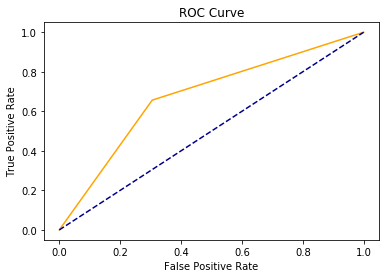

In [72]:
roc_plot(clf ,test_x , test_y)

- Here we are facing the tradeoff b/w recall and precision. So we need to choose the threshold according to our use case requirement.

In [78]:
# Saving Logistic Regression Model

filename = 'My_Logistic_Regression_Model.pickle'
pickle.dump(clf , open(filename, 'wb'))

In [79]:
# Saving Scaled Model

filename = 'Scaled_model.pickle'
pickle.dump(scaler , open(filename, 'wb'))

In [89]:
# Prediction

load_model = pickle.load(open('My_Logistic_Regression_Model.pickle','rb'))
load_scaler = pickle.load(open('Scaled_model.pickle', 'rb'))

values = list(x.iloc[45])   # [5.0, 0.0, 3.0, 12.0, 3.0, 2.0, 24.5]

    
prob = load_model.predict_proba(load_scaler.transform([values]))[:,1]
threshold = 0.4
if prob > threshold :
    print('Have atleast one affair')
else :
    print('No affair')


No affair
